In [1]:
pip install torch transformers datasets numpy matplotlib tqdm psutil bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U bitsandbytes

In [5]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil
import os
import time
import gc
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import copy


In [6]:
class TextDataset(Dataset):
    """Custom Dataset for GPT2"""
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [7]:
class MemoryTracker:
    """Memory tracking utility"""
    def __init__(self):
        self.process = psutil.Process(os.getpid())
    
    def get_memory_usage(self):
        """Get current memory usage in MB"""
        return self.process.memory_info().rss / 1024 / 1024
    
    def get_gpu_memory(self):
        """Get GPU memory usage in MB"""
        if torch.cuda.is_available():
            return torch.cuda.memory_allocated() / 1024 / 1024
        return 0

In [14]:
class ModelQuantizer:
    """Handles different quantization methods using bitsandbytes"""
    def __init__(self, model_name='gpt2', device='cuda'):
        self.model_name = model_name
        self.device = device
        self.original_model = None
        self.model_8bit = None
        self.model_4bit = None
        self.model_nf4 = None
        
    def load_original_model(self):
        """Load the original FP16/32 model"""
        self.original_model = AutoModelForCausalLM.from_pretrained(
            self.model_name
        ).to(self.device)
        return self.original_model
    
    def load_8bit_model(self):
        """Load 8-bit quantized model"""
        self.model_8bit = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_8bit=True,
            device_map='auto'
        )
        torch.save(self.model_8bit.state_dict(), 'gpt2_8bit_quantized.pth')
        return self.model_8bit
    
    def load_4bit_model(self):
        """Load 4-bit quantized model"""
        self.model_4bit = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            device_map='auto'
        )
        torch.save(self.model_4bit.state_dict(), 'gpt2_4bit_quantized.pth')
        return self.model_4bit
    
    def load_nf4_model(self):
        """Load NF4 quantized model"""
        self.model_nf4 = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            device_map='auto'
        )
        torch.save(self.model_nf4.state_dict(), 'gpt2_nf4_quantized.pth')
        return self.model_nf4


In [15]:
def prepare_dataset(tokenizer, max_length=512):
    """Prepare Wikipedia dataset for evaluation"""
    dataset = load_dataset("wikipedia", "20220301.en", split="train[:3000]")
    
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
    
    encodings = tokenize_function(dataset)
    dataset = TextDataset(encodings)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
    
    return dataloader

In [16]:
def calculate_perplexity(model, eval_dataloader, device):
    """Calculate model perplexity"""
    model.eval()
    total_loss = 0
    total_length = 0
    
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Calculating perplexity"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = input_ids.clone()
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                          shift_labels.view(-1))
            
            total_loss += loss.item()
            total_length += attention_mask.sum().item()
    
    return torch.exp(torch.tensor(total_loss / total_length))

In [17]:
def measure_inference_latency(model, input_ids, attention_mask, num_runs=200):
    """Measure inference latency"""
    latencies = []
    model.eval()
    
    with torch.no_grad():
        # Warmup
        for _ in range(10):
            _ = model(input_ids, attention_mask=attention_mask)
        
        # Measure latency
        for _ in tqdm(range(num_runs), desc="Measuring latency"):
            start_time = time.time()
            _ = model(input_ids, attention_mask=attention_mask)
            latencies.append((time.time() - start_time) * 1000)  # Convert to ms
    
    return np.mean(latencies), np.std(latencies)

In [29]:
def plot_comparison(metrics, title, ylabel):
    """Plot comparison metrics with enhanced y-axis scaling"""
    plt.figure(figsize=(10, 6))
    x = range(len(metrics['labels']))
    
    # Create bar plot
    bars = plt.bar(x, metrics['values'], color='skyblue')
    plt.xticks(x, metrics['labels'], rotation=45)
    plt.title(title)
    plt.ylabel(ylabel)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    # Adjust y-axis scale for better visualization
    y_min = min(metrics['values']) * 0.95
    y_max = max(metrics['values']) * 1.05
    plt.ylim(y_min, y_max)
    
    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize components
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
memory_tracker = MemoryTracker()
quantizer = ModelQuantizer('gpt2', device)

# Prepare dataset
eval_dataloader = prepare_dataset(tokenizer)


Using device: cuda


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# Dictionary to store results
results = {
    'memory': {'labels': [], 'values': []},
    'memory_usage': {'labels': [], 'values': []},  # Added for memory usage
    'perplexity': {'labels': [], 'values': []},
    'latency': {'labels': [], 'values': []},
}

# Test original model
print("\nTesting original model...")
model = quantizer.load_original_model()
sample_batch = next(iter(eval_dataloader))

results['memory']['labels'].append('Original')
results['memory']['values'].append(memory_tracker.get_gpu_memory())

# Track memory usage
results['memory_usage']['labels'].append('Original')
results['memory_usage']['values'].append(memory_tracker.get_memory_usage())

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('Original')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('Original')
results['latency']['values'].append(latency)

del model
gc.collect()
torch.cuda.empty_cache()


Testing original model...


/tmp/ipykernel_31/572362101.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


In [21]:
# Test 8-bit quantization
print("\nTesting 8-bit quantization...")
model = quantizer.load_8bit_model()

results['memory']['labels'].append('8-bit')
results['memory']['values'].append(memory_tracker.get_gpu_memory())

# Track memory usage
results['memory_usage']['labels'].append('8-bit')
results['memory_usage']['values'].append(memory_tracker.get_memory_usage())

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('8-bit')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('8-bit')
results['latency']['values'].append(latency)
 
del model
gc.collect()
torch.cuda.empty_cache()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing 8-bit quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_31/572362101.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


In [22]:
# Test 4-bit linear quantization
print("\nTesting 4-bit linear quantization...")
model = quantizer.load_4bit_model()

results['memory']['labels'].append('4-bit')
results['memory']['values'].append(memory_tracker.get_gpu_memory())

# Track memory usage
results['memory_usage']['labels'].append('4-bit')
results['memory_usage']['values'].append(memory_tracker.get_memory_usage())

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('4-bit')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('4-bit')
results['latency']['values'].append(latency)

del model
gc.collect()
torch.cuda.empty_cache()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing 4-bit linear quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_31/572362101.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


In [23]:
# Test NF4 quantization
print("\nTesting NF4 quantization...")
model = quantizer.load_nf4_model()

results['memory']['labels'].append('NF4')
results['memory']['values'].append(memory_tracker.get_gpu_memory())

# Track memory usage
results['memory_usage']['labels'].append('NF4')
results['memory_usage']['values'].append(memory_tracker.get_memory_usage())

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('NF4')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('NF4')
results['latency']['values'].append(latency)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing NF4 quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_31/572362101.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:21<00:00,  9.27it/s]


In [25]:
# Print summary
print("\nQuantization Results Summary:")
print("\nMemory Usage (MB):")
for label, value in zip(results['memory']['labels'], results['memory']['values']):
    print(f"  {label}: {value:.2f}")
    
print("\nDetailed Memory Usage (MB):")
for label, value in zip(results['memory_usage']['labels'], results['memory_usage']['values']):
    print(f"  {label}: {value:.2f}")

print("\nPerplexity:")
for label, value in zip(results['perplexity']['labels'], results['perplexity']['values']):
    print(f"  {label}: {value:.2f}")
    
print("\nInference Latency (ms):")
for label, value in zip(results['latency']['labels'], results['latency']['values']):
    print(f"  {label}: {value:.2f}")


Quantization Results Summary:

Memory Usage (MB):
  Original: 652.13
  8-bit: 559.76
  4-bit: 610.20
  NF4: 655.63

Detailed Memory Usage (MB):
  Original: 4153.11
  8-bit: 4141.84
  4-bit: 4141.64
  NF4: 4266.33

Perplexity:
  Original: 41.00
  8-bit: 41.48
  4-bit: 44.55
  NF4: 44.45

Inference Latency (ms):
  Original: 321.32
  8-bit: 165.73
  4-bit: 106.36
  NF4: 106.68


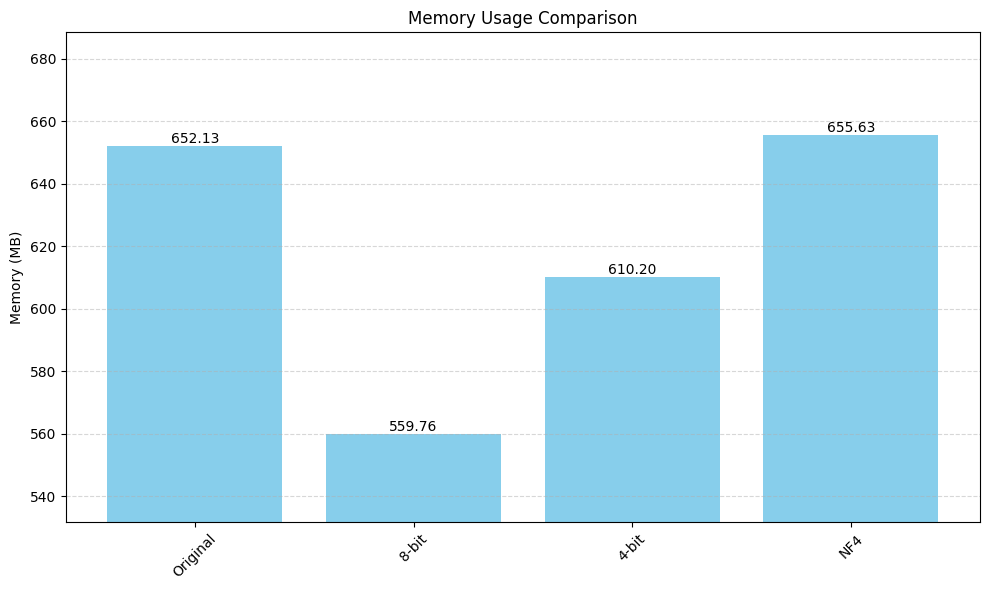

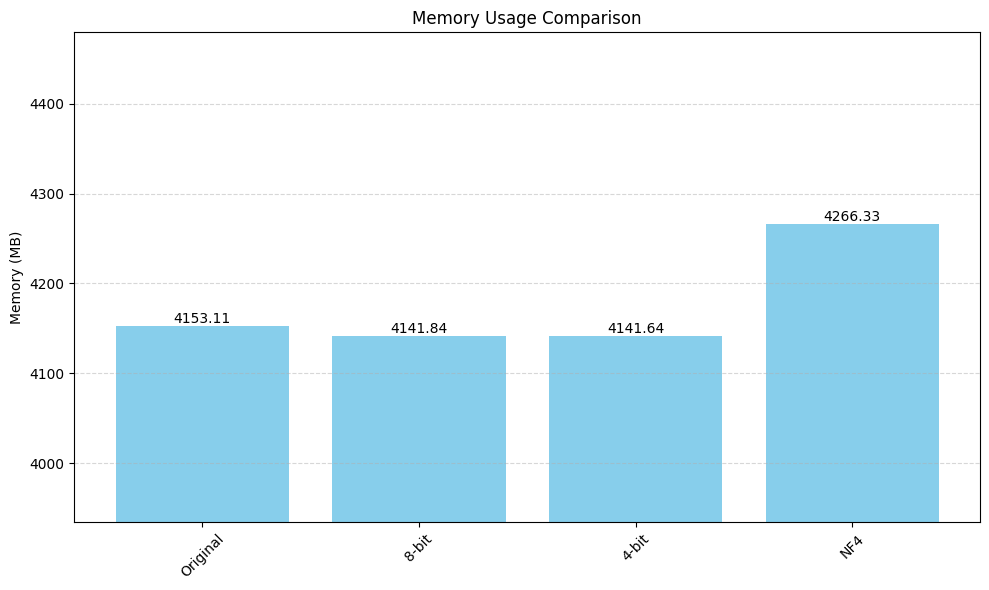

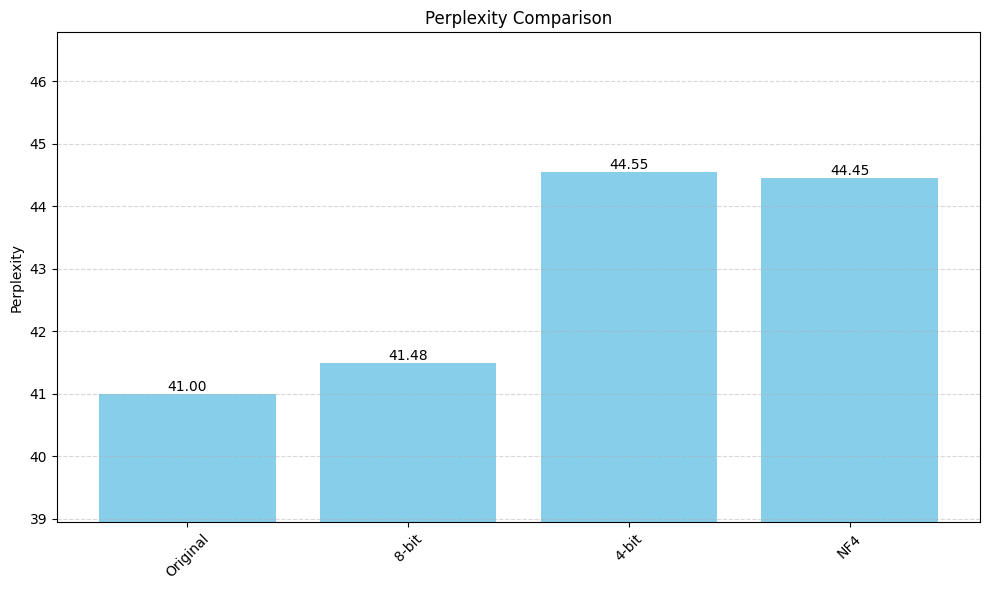

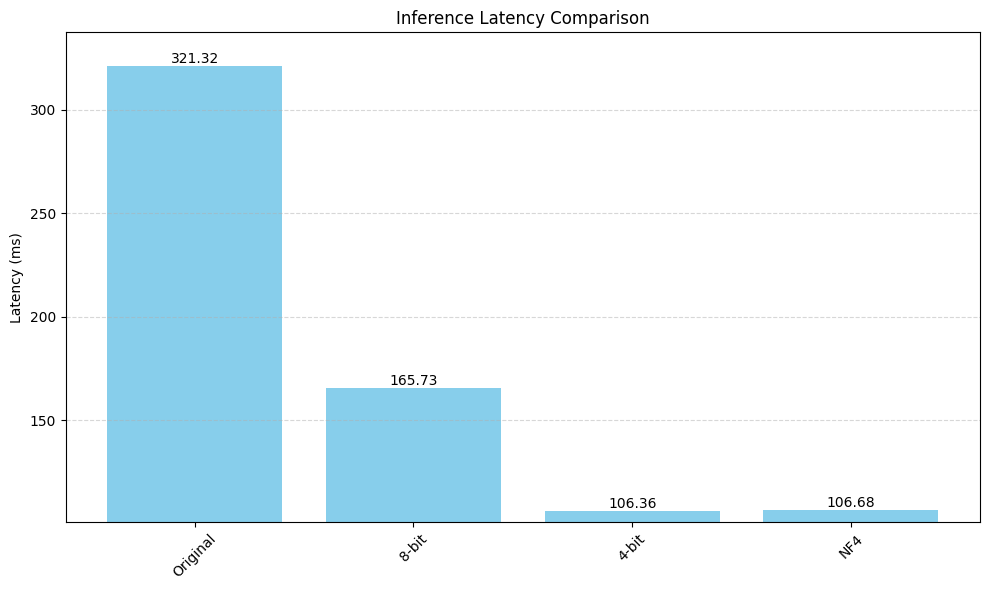

In [30]:
# Plot results directly without saving to a file
plot_comparison(results['memory'], 
               'Memory Usage Comparison', 
               'Memory (MB)')

plot_comparison(results['memory_usage'], 
               'Memory Usage Comparison', 
               'Memory (MB)')

plot_comparison(results['perplexity'], 
               'Perplexity Comparison',
               'Perplexity')

plot_comparison(results['latency'], 
               'Inference Latency Comparison',
               'Latency (ms)')